# Start-to-Finish Example: Numerical Solution of the Scalar Wave Equation, in Curvilinear Coordinates

## Author: Zach Etienne
### Formatting improvements courtesy Brandon Clark

## This module solves the scalar wave equation for a plane wave in *spherical coordinates*

<font color='green'>**This module has been validated to converge at the expected order to the exact solution (see [plot](#convergence) at bottom).**</font>

### NRPy+ Source Code for this module: 
* [ScalarWaveCurvilinear/ScalarWaveCurvilinear_RHSs.py](../edit/ScalarWaveCurvlinear/ScalarWaveCurvilinear_RHSs.py) [\[**tutorial**\]](Tutorial-ScalarWaveCurvilinear.ipynb) Generates the right-hand side for the Scalar Wave Equation in curvilinear coordinates
* [ScalarWave/InitialData_PlaneWave.py](../edit/ScalarWave/InitialData_PlaneWave.py) [\[**tutorial**\]](Tutorial-ScalarWave.ipynb) Generating C code for plane wave initial data for the scalar wave equation 

## Introduction:
As outlined in the [previous NRPy+ tutorial module](Tutorial-ScalarWaveCurvilinear.ipynb), we first use NRPy+ to generate initial data for the scalar wave equation, and then we use it to generate the RHS expressions for [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on the [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4).

The entire algorithm is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. <font color='green'>Set gridfunction values to initial data.</font>
1. Evolve the system forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. <font color='green'>Evaluate scalar wave RHS expressions.</font>
    1. Apply boundary conditions.
1. At the end of each iteration in time, output the relative error between numerical and exact solutions.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This module is organized as follows

1. [Step 1](#outputc): Call on NRPy+ to output needed C code for initial data and scalar wave RHSs
    1. [Step 1.a](#ref_metric): Output quantities related to reference metric
1. [Step 2](#writec): Writing the necessary C code infrastructure to solve the scalar wave equation in curvilinear, singular coordinates
    1. [Step 2.a](#bcs): Write needed C code for implementing boundary condition algorithm above
    1. [Step 2.b](#cfl): Output needed C code for finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep
1. [Step 3](#mainc): $\rm{ScalarWaveCurvilinear\_Playground.c}$: The Main C Code
1. [Step 4](#convergence): Code validation: Verify that relative error in numerical solution converges to zero at the expected order
1. [Step 5](#latex_pdf_output): Output this module to $\LaTeX$-formatted PDF file

<a id='outputc'></a>

# Step 1: Call on NRPy+ to output needed C code for initial data and scalar wave RHSs \[Back to [top](#toc)\]
$$\label{outputc}$$


We choose simple plane wave initial data, which is documented in the [Cartesian scalar wave module](Tutorial-ScalarWave.ipynb). Specifically, we implement monochromatic (single-wavelength) wave traveling in the $\hat{k}$ direction with speed $c$
$$u(\vec{x},t) = f(\hat{k}\cdot\vec{x} - c t),$$
where $\hat{k}$ is a unit vector.

The scalar wave RHSs in curvilinear coordinates (documented [in the previous module](Tutorial-ScalarWaveCurvilinear.ipynb)) are simply the right-hand sides of the scalar wave equation written in curvilinear coordinates
\begin{align}
\partial_t u &= v \\
\partial_t v &= c^2 \left(\hat{g}^{ij} \partial_{i} \partial_{j} u - \hat{\Gamma}^i \partial_i u\right),
\end{align}
where $\hat{g}^{ij}$ is the inverse reference 3-metric (i.e., the metric corresponding to the underlying coordinate system we choose$-$spherical coordinates in our example below), and $\hat{\Gamma}^i$ is the contracted Christoffel symbol $\hat{\Gamma}^\tau = \hat{g}^{\mu\nu} \hat{\Gamma}^\tau_{\mu\nu}$.

Below we generate 
+ the initial data by calling `InitialData_PlaneWave()` inside the NRPy+ [ScalarWave/InitialData_PlaneWave.py](../edit/ScalarWave/InitialData_PlaneWave.py) module (documented in [this NRPy+ Jupyter notebook](Tutorial-ScalarWave.ipynb)), and 
+ the RHS expressions by calling `ScalarWaveCurvilinear_RHSs()` inside the NRPy+ [ScalarWaveCurvilinear/ScalarWaveCurvilinear_RHSs.py](../edit/ScalarWaveCurvilinear/ScalarWaveCurvilinear_RHSs.py) module (documented in [this NRPy+ Jupyter notebook](Tutorial-ScalarWaveCurvilinear.ipynb)).

In [1]:
# Step P1: Import needed NRPy+ core modules:
import NRPy_param_funcs as par
import indexedexp as ixp
import grid as gri
import reference_metric as rfm
import finite_difference as fin
import loop as lp
from outputC import *
import sys

# Step P2: Set the coordinate system for the numerical grid
par.set_parval_from_str("reference_metric::CoordSystem","SinhSpherical")

# Step 1: Import the ScalarWave.InitialData module. 
#         This command only declares ScalarWave initial data 
#         parameters and the InitialData_PlaneWave() function.
import ScalarWave.InitialData_PlaneWave as swid

# Step 2: Import ScalarWave_RHSs module. 
#         This command only declares ScalarWave RHS parameters
#         and the ScalarWave_RHSs function (called later)
import ScalarWaveCurvilinear.ScalarWaveCurvilinear_RHSs as swrhs

# Step 3: Set the spatial dimension parameter 
#         to *FOUR* this time, and then read
#         the parameter as DIM.
par.set_parval_from_str("grid::DIM",3)
DIM = par.parval_from_str("grid::DIM")

# Step 4: Set the finite differencing order to 6.
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER",4)

# Step 5: Call the InitialData_PlaneWave() function to set up
#         monochromatic (single frequency/wavelength) scalar
#         wave initial data.
swid.InitialData_PlaneWave()

# Step 6: Generate SymPy symbolic expressions for
#         uu_rhs and vv_rhs; the ScalarWave RHSs.
#         This function also declares the uu and vv
#         gridfunctions, which need to be declared
#         to output even the initial data to C file.
swrhs.ScalarWaveCurvilinear_RHSs()

# Step 7: Generate C code for the initial data,
#         output to a file named "SENR/ScalarWave_InitialData.h".
IDstring = fin.FD_outputC("returnstring",[lhrh(lhs=gri.gfaccess("in_gfs","uu"),rhs=swid.uu_ID),
                                          lhrh(lhs=gri.gfaccess("in_gfs","vv"),rhs=swid.vv_ID)])
with open("ScalarWaveCurvilinear/ScalarWaveCartesian_ExactSolution.h", "w") as file:
    file.write(IDstring)

# Step 8: Generate C code for scalarwave RHSs,
#         output to a file named "SENR/ScalarWave_RHSs.h".
RHSstring = fin.FD_outputC("returnstring",[lhrh(lhs=gri.gfaccess("rhs_gfs","uu"),rhs=swrhs.uu_rhs),
                                           lhrh(lhs=gri.gfaccess("rhs_gfs","vv"),rhs=swrhs.vv_rhs)])
with open("ScalarWaveCurvilinear/ScalarWaveCurvilinear_RHSs.h", "w") as file:
    file.write(lp.loop(["i2","i1","i0"],["NGHOSTS","NGHOSTS","NGHOSTS"],
                       ["NGHOSTS+Nxx[2]","NGHOSTS+Nxx[1]","NGHOSTS+Nxx[0]"],
                       ["1","1","1"],["const REAL invdx0 = 1.0/dxx[0];\n"+
                                      "const REAL invdx1 = 1.0/dxx[1];\n"+
                                      "const REAL invdx2 = 1.0/dxx[2];\n"+
                                      "#pragma omp parallel for",
                                      "    const REAL xx2 = xx[2][i2];",
                                      "        const REAL xx1 = xx[1][i1];"],"",
                                     "const REAL xx0 = xx[0][i0];\n"+RHSstring))

<a id='ref_metric'></a>

## Step 1.a Output quantities related to reference metric \[Back to [top](#toc)\]
$$\label{ref_metric}$$

There are several subtleties when generalizing the [start-to-finish scalar wave tutorial in Cartesian coordinates](Tutorial-Start_to_Finish-ScalarWave.ipynb) to curvilinear coordinates. 

Consider for example *ordinary* (as opposed to, e.g., logarithmic-radial) spherical coordinates. In these coordinates, we choose a *uniform* grid in $(x_0,x_1,x_2)=(r,\theta,\phi)$. That is to say, we choose *constant* spacing $\Delta r$, $\Delta \theta$, and $\Delta \phi$ between grid points in $r$, $\theta$, and $\phi$, respectively.

+ Unlike Cartesian coordinates, in which our computational domain with coordinates $(x_0,x_1,x_2)=(x,y,z)$ may extend over arbitrary coordinate ranges $x_i \in [x_{i, \rm min},x_{i, \rm max}]$, our spherical coordinate domains will satisfy

    + $x_0 = r \in [0,{\rm RMAX}]$,
    + $x_1 = \theta \in [0,\pi]$, and
    + $x_2 = \phi \in [-\pi,\pi]$. (Notice how we do not choose $x_2= \phi \in [0,2\pi]$ so that our conversion from Cartesian to spherical coordinates is compatible with the output range from the ${\rm atan2}(y,x)$ function: $\phi={\rm atan2}(y,x)\in[-\pi,\pi]$.)

+ Further, most non-Cartesian, orthogonal coordinate systems (like spherical coordinates) possess *coordinate singularities*. Coordinate singularities in spherical coordinates lie along $\theta=0$ and $\theta=\pi$; these are points where the coordinate system focuses to a single point. For example, the coordinate singularity at the North Pole is the reason why all directions are south there. Critically, these singularities manifest as points where the reference metric or its inverse crosses through zero or diverges to $\infty$. As we derived in a [previous module](Tutorial-ScalarWaveCurvilinear.ipynb), the Laplacian in spherical polar coordinates takes the form
$$
\nabla^2 u = \partial_r^2 u + \frac{1}{r^2} \partial_\theta^2 u + \frac{1}{r^2 \sin^2 \theta} \partial_\phi^2 u +  \frac{2}{r} \partial_r u + \frac{\cos\theta}{r^2 \sin\theta} \partial_\theta u,
$$
which diverges at $r=0$ and $\sin\theta=0-$precisesly at the $\theta=0$ and $\theta=\pi$ coordinate singularity. To avoid this divergence, we simply choose that our numerical grids be *cell-centered*. For example, if we choose a numerical grid with 3 outer ghost zone points (needed due to 6th-order-accurate centered finite differencing), and we want the grid interior to be sampled with ${\rm Nr}\times{\rm Ntheta}\times{\rm Nphi}$ grid points, then the cell-centered grid points can be indexed via three *even* integers $\left(\rm{i0}\in[0,{\rm Nr}+6),\rm{i1}\in[0,{\rm Ntheta}+6),\rm{i2}\in[0,{\rm Ntheta}+6)\right)$:
    + $r_{\rm i0}      = r_{\rm min}      + \left({\rm i0} + \frac{1}{2}\right)\Delta r$, where $r_{\rm min}=\left(-3+\frac{1}{2}\right)\Delta r$;
    + $\theta_{\rm i1} = \theta_{\rm min} + \left({\rm i1} + \frac{1}{2}\right)\Delta \theta$, where $\theta_{\rm min}= \left(-3+\frac{1}{2}\right)\Delta \theta$; and
    + $\phi_{\rm i2}   = \phi_{\rm min}   + \left({\rm i2} + \frac{1}{2}\right)\Delta \phi$, where $\phi_{\rm min}=-\pi+ \left(-3+\frac{1}{2}\right)\Delta \phi$.

+ Unlike Cartesian coordinates, the boundaries of our grid $x_i \in [x_{i, \rm min},x_{i, \rm max}]$ in spherical coordinates are not all outer boundaries. This presents some additional challenges, as finite difference numerical grids of $N$th order accuracy generally possess $N/2$ *ghost zone points* in regions $x_i < x_{i,\rm min}$ and $x_i > x_{i, \rm max}$. While in Cartesian coordinates, these ghost zone points map to regions outside the grid domain $x_i \in [x_{i, \rm min},x_{i, \rm max}]$, in spherical coordinates, most ghost zone points map to regions *inside* the grid domain. For example, for some $\tilde{r}\in [0,{\rm RMAX}]$ and $\tilde{\theta}\in[0,\pi]$, the ghost zone point $(\tilde{r},\tilde{\theta},2\pi+\Delta \phi/2)$ would map to the interior point $(\tilde{r},\tilde{\theta},\Delta \phi/2)$ because the $\phi$ coordinate is periodic. Thus when given a ghost zone point in some non-Cartesian coordinate system, we are faced with the problem of addressing the following two questions:
    1. Does a given ghost point map to an interior point, or is it an outer boundary point (i.e., a point exterior to the domain)?
    1. If the ghost zone point maps to an interior point, to which interior point does it map?

We handle ghost zone points outside the domain boundary in generic coordinate systems by applying the following, simple process at each ghost zone point:
1. Convert the coordinate $(x_0,x_1,x_2)$ for the ghost zone point to Cartesian coordinates $\left(x(x_0,x_1,x_2),y(x_0,x_1,x_2),z(x_0,x_1,x_2)\right)$. For example, if we choose ordinary spherical coordinates $(x_0,x_1,x_2)=(r,\theta,\phi)$, then
    + $x(r,\theta,\phi) = r \sin(\theta) \cos(\phi) = x_0 \sin(x_1) \cos(x_2)$
    + $y(r,\theta,\phi) = r \sin(\theta) \sin(\phi) = x_0 \sin(x_1) \sin(x_2)$
    + $z(r,\theta,\phi) = r \cos(\theta)            = x_0 \cos(x_1)$
1. Once we have $(x,y,z)$, we then find the corresponding value $(x_0,x_1,x_2)_{\rm in/OB}=(r,\theta,\phi)_{\rm in/OB}$ *in the grid interior or outer boundary*, via the simple inverse formula:
    + $r_{\rm in/OB}      = x_{0, \rm in/OB} = \sqrt{x^2+y^2+z^2} \in [0,\infty)$
    + $\theta_{\rm in/OB} = x_{1, \rm in/OB} = {\rm acos}\left(\frac{z}{\sqrt{x^2+y^2+z^2}}\right) \in [0,\pi]$
    + $\phi_{\rm in/OB}   = x_{2, \rm in/OB} = {\rm atan2}(y,x) \in [-\pi,\pi]$ [Wikipedia article on atan2()](https://en.wikipedia.org/w/index.php?title=Atan2&oldid=859313982)

1. If $(x_0,x_1,x_2)_{\rm in/OB}$ is the same as the original $(x_0,x_1,x_2)$, then we know $(x_0,x_1,x_2)$ is an outer boundary point (in spherical coordinates, at $r>{\rm RMAX}$), and we store $\left(\rm{i0},\rm{i1},\rm{i2}\right)_{\rm in/OB} = (-1,-1,-1)$. Otherwise, we know that $(x_0,x_1,x_2)$ maps to some interior point at index $(\rm{i0},\rm{i1},\rm{i2})$, which we store:
    + $\rm{i0}_{\rm in/OB}=\frac{r_{\rm in/OB}      -      r_{\rm min}}{\Delta r}      - \frac{1}{2}$
    + $\rm{i1}_{\rm in/OB}=\frac{\theta_{\rm in/OB} - \theta_{\rm min}}{\Delta \theta} - \frac{1}{2}$
    + $\rm{i2}_{\rm in/OB}=\frac{\phi_{\rm in/OB}   -   \phi_{\rm min}}{\Delta \phi}   - \frac{1}{2}$

1. When updating a ghost zone point $\left(\rm{i0},\rm{i1},\rm{i2}\right)$ in the domain exterior, if the corresponding $\left(\rm{i0},\rm{i1},\rm{i2}\right)_{\rm in/OB}$ was set to $(-1,-1,-1)$, then we apply outer boundary conditions. Otherwise, we simply copy the data from the interior point at $\left(\rm{i0},\rm{i1},\rm{i2}\right)_{\rm in/OB}$ to $\left(\rm{i0},\rm{i1},\rm{i2}\right)$.

**Exercise to student: Given the prescripion above, why do the integers $\left(\rm{i0},\rm{i1},\rm{i2}\right)$ need to be even?**

Next we generate the C code needed for applying boundary conditions in generic coordinate systems (and, in the case of "xxminmax.h", to set up the numerical grid coordinates as well):
1. $(x_{0},x_{1},x_{2})_{\rm min}$, $(x_{0},x_{1},x_{2})_{\rm max}$, (ScalarWaveCurvilinear/xxminmax.h)
1. $\left(x(x_0,x_1,x_2),y(x_0,x_1,x_2),z(x_0,x_1,x_2)\right)$, (ScalarWaveCurvilinear/xxCart.h)
1. $\left(x_0(x,y,z),x_1(x,y,z),x_2(x,y,z)\right)$, (ScalarWaveCurvilinear/Cart_to_xx.h):

In [2]:
# Generic coordinate NRPy+ file output, Part 1: output the coordinate bounds xxmin[] and xxmax[]:
with open("ScalarWaveCurvilinear/xxminmax.h", "w") as file:
    file.write("const REAL xxmin[3] = {"+str(rfm.xxmin[0])+","+str(rfm.xxmin[1])+","+str(rfm.xxmin[2])+"};\n")
    file.write("const REAL xxmax[3] = {"+str(rfm.xxmax[0])+","+str(rfm.xxmax[1])+","+str(rfm.xxmax[2])+"};\n")
# Generic coordinate NRPy+ file output, Part 2: output the conversion from (x0,x1,x2) to Cartesian (x,y,z)
outputC([rfm.xxCart[0],rfm.xxCart[1],rfm.xxCart[2]],["xCart[0]","xCart[1]","xCart[2]"],
        "ScalarWaveCurvilinear/xxCart.h")
# Generic coordinate NRPy+ file output, Part 3: output the conversion from Cartesian (x,y,z) to interior/OB (x0,x1,x2)
# First make sure that rfm.Cart_to_xx has been set. Error out if not!
if rfm.Cart_to_xx[0] == 0 or rfm.Cart_to_xx[1] == 0 or rfm.Cart_to_xx[2] == 0:
    print("ERROR: rfm.Cart_to_xx[], which maps Cartesian -> xx, has not been set for")
    print("       reference_metric::CoordSystem = "+par.parval_from_str("reference_metric::CoordSystem"))
    print("       Boundary conditions in curvilinear coordinates REQUiRE this be set.")
    sys.exit(1)
outputC([rfm.Cart_to_xx[0],rfm.Cart_to_xx[1],rfm.Cart_to_xx[2]],
        ["Cart_to_xx0_inbounds","Cart_to_xx1_inbounds","Cart_to_xx2_inbounds"],
        "ScalarWaveCurvilinear/Cart_to_xx.h")

Wrote to file "ScalarWaveCurvilinear/xxCart.h"
Wrote to file "ScalarWaveCurvilinear/Cart_to_xx.h"


<a id='writec'></a>

# Step 2: Writing the necessary C code infrastructure to solve the scalar wave equation in curvilinear, singular coordinates \[Back to [top](#toc)\]
$$\label{writec}$$


<a id='bcs'></a>

## Step 2.a: Write needed C code for implementing boundary condition algorithm above \[Back to [top](#toc)\]
$$\label{bcs}$$

In [3]:
%%writefile ScalarWaveCurvilinear/curvilinear_boundary_conditions.h

typedef struct ghostzone_map {
  short i0,i1,i2;
} gz_map;

void set_up_bc_gz_map(const int Nxx_plus_2NGHOSTS[3], REAL *xx[3], const REAL dxx[3], const REAL xxmin[3], const REAL xxmax[3], gz_map *bc_gz_map) {
  LOOP_REGION(0,Nxx_plus_2NGHOSTS[0],0,Nxx_plus_2NGHOSTS[1],0,Nxx_plus_2NGHOSTS[2]) {
    REAL xCart[3];
    xxCart(xx, i0,i1,i2, xCart);
    REAL Cartx = xCart[0];
    REAL Carty = xCart[1];
    REAL Cartz = xCart[2];
    
    REAL Cart_to_xx0_inbounds,Cart_to_xx1_inbounds,Cart_to_xx2_inbounds;
#include "Cart_to_xx.h"
    int i0_inbounds = (int)( (Cart_to_xx0_inbounds - xxmin[0] - (1.0/2.0)*dxx[0] + ((REAL)NGHOSTS)*dxx[0])/dxx[0] + 0.5 ); 
    int i1_inbounds = (int)( (Cart_to_xx1_inbounds - xxmin[1] - (1.0/2.0)*dxx[1] + ((REAL)NGHOSTS)*dxx[1])/dxx[1] + 0.5 );
    int i2_inbounds = (int)( (Cart_to_xx2_inbounds - xxmin[2] - (1.0/2.0)*dxx[2] + ((REAL)NGHOSTS)*dxx[2])/dxx[2] + 0.5 );

    REAL xCart_orig[3]; for(int ii=0;ii<3;ii++) xCart_orig[ii] = xCart[ii];
    xxCart(xx, i0_inbounds,i1_inbounds,i2_inbounds, xCart);

//fprintf(stderr,"Cartesian agreement: ( %.15e %.15e %.15e ) ?= ( %.15e %.15e %.15e )\n",
// (double)xCart_orig[0],(double)xCart_orig[1],(double)xCart_orig[2],
// (double)xCart[0],(double)xCart[1],(double)xCart[2]);
      
#define EPS_ABS 1e-8
    if(fabs( (double)(xCart_orig[0] - xCart[0]) ) > EPS_ABS ||
       fabs( (double)(xCart_orig[1] - xCart[1]) ) > EPS_ABS ||
       fabs( (double)(xCart_orig[2] - xCart[2]) ) > EPS_ABS) {
      fprintf(stderr,"Error. Cartesian disagreement: ( %.15e %.15e %.15e ) != ( %.15e %.15e %.15e )\n",
             (double)xCart_orig[0],(double)xCart_orig[1],(double)xCart_orig[2],
             (double)xCart[0],(double)xCart[1],(double)xCart[2]);
      exit(1);
    }

    if(i0_inbounds-i0 == 0 && i1_inbounds-i1 == 0 && i2_inbounds-i2 == 0) {
      bc_gz_map[IDX3(i0,i1,i2)].i0=-1;
      bc_gz_map[IDX3(i0,i1,i2)].i1=-1;
      bc_gz_map[IDX3(i0,i1,i2)].i2=-1;
    } else {
      bc_gz_map[IDX3(i0,i1,i2)].i0=i0_inbounds;
      bc_gz_map[IDX3(i0,i1,i2)].i1=i1_inbounds;
      bc_gz_map[IDX3(i0,i1,i2)].i2=i2_inbounds;
    }
  }
}

// Part P6: Declare boundary condition OB_UPDATE macro,
//          which updates a single face of the 3D grid cube
//          using quadratic polynomial extrapolation.
const int MAXFACE = -1;
const int NUL     = +0;
const int MINFACE = +1;


#define OB_UPDATE(inner,which_gf, bc_gz_map, i0min,i0max, i1min,i1max, i2min,i2max, FACEX0,FACEX1,FACEX2) \
  LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) {                  \
    const int idx3 = IDX3(i0,i1,i2);                                    \
    if(bc_gz_map[idx3].i0 == -1 && inner==0) {                          \
      gfs[IDX4(which_gf,i0,i1,i2)] =                                    \
        +3.0*gfs[IDX4(which_gf,i0+1*FACEX0,i1+1*FACEX1,i2+1*FACEX2)]    \
        -3.0*gfs[IDX4(which_gf,i0+2*FACEX0,i1+2*FACEX1,i2+2*FACEX2)]    \
        +1.0*gfs[IDX4(which_gf,i0+3*FACEX0,i1+3*FACEX1,i2+3*FACEX2)];   \
    } else if(bc_gz_map[idx3].i0 != -1 && inner==1) {                   \
      gfs[IDX4(which_gf,i0,i1,i2)] =                                    \
        gfs[IDX4(which_gf,                                              \
                 bc_gz_map[idx3].i0,                                    \
                 bc_gz_map[idx3].i1,                                    \
                 bc_gz_map[idx3].i2)];                                  \
    }                                                                   \
  }

// Part P7: Boundary condition driver routine: Apply BCs to all six
//          boundary faces of the cube, filling in the innermost
//          ghost zone first, and moving outward.
void apply_bcs(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],gz_map *bc_gz_map,REAL *gfs) {
#pragma omp parallel for
  for(int which_gf=0;which_gf<NUM_GFS;which_gf++) {
    int imin[3] = { NGHOSTS, NGHOSTS, NGHOSTS };
    int imax[3] = { Nxx_plus_2NGHOSTS[0]-NGHOSTS, Nxx_plus_2NGHOSTS[1]-NGHOSTS, Nxx_plus_2NGHOSTS[2]-NGHOSTS };
    for(int which_gz = 0; which_gz < NGHOSTS; which_gz++) {
      for(int inner=0;inner<2;inner++) {
        // After updating each face, adjust imin[] and imax[] 
        //   to reflect the newly-updated face extents.
        OB_UPDATE(inner,which_gf, bc_gz_map, imin[0]-1,imin[0], imin[1],imax[1], imin[2],imax[2], MINFACE,NUL,NUL); imin[0]--;
        OB_UPDATE(inner,which_gf, bc_gz_map, imax[0],imax[0]+1, imin[1],imax[1], imin[2],imax[2], MAXFACE,NUL,NUL); imax[0]++;

        OB_UPDATE(inner,which_gf, bc_gz_map, imin[0],imax[0], imin[1]-1,imin[1], imin[2],imax[2], NUL,MINFACE,NUL); imin[1]--;
        OB_UPDATE(inner,which_gf, bc_gz_map, imin[0],imax[0], imax[1],imax[1]+1, imin[2],imax[2], NUL,MAXFACE,NUL); imax[1]++;

        OB_UPDATE(inner,which_gf, bc_gz_map, imin[0],imax[0], imin[1],imax[1], imin[2]-1,imin[2], NUL,NUL,MINFACE); imin[2]--;
        OB_UPDATE(inner,which_gf, bc_gz_map, imin[0],imax[0], imin[1],imax[1], imax[2],imax[2]+1, NUL,NUL,MAXFACE); imax[2]++;
        if(inner==0) { for(int ii=0;ii<3;ii++) {imin[ii]++; imax[ii]--;} }
      }
    }
  }
}

Overwriting ScalarWaveCurvilinear/curvilinear_boundary_conditions.h


<a id='cfl'></a>

## Step 2.b: Output needed C code for finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep \[Back to [top](#toc)\]
$$\label{cfl}$$

In order for our explicit-timestepping numerical solution to the scalar wave equation to be stable, it must satisfy the [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673) condition:
$$
\Delta t \le \frac{\min(ds_i)}{c},
$$
where $c$ is the wavespeed, and
$$ds_i = h_i \Delta x^i$$ 
is the proper distance between neighboring gridpoints in the $i$th direction (in 3D, there are 3 directions), $h_i$ is the $i$th reference metric scale factor, and $\Delta x^i$ is the uniform grid spacing in the $i$th direction:

In [4]:
# Generic coordinate NRPy+ file output, Part 4: output the proper distance between gridpoints in given coordinate system
dxx     = ixp.declarerank1("dxx",DIM=3)
ds_dirn = rfm.ds_dirn(dxx)
outputC([ds_dirn[0],ds_dirn[1],ds_dirn[2]],["ds_dirn0","ds_dirn1","ds_dirn2"],"ScalarWaveCurvilinear/ds_dirn.h")

Wrote to file "ScalarWaveCurvilinear/ds_dirn.h"


<a id='mainc'></a>

# Step 3: $\rm{ScalarWaveCurvilinear\_Playground.c}$: The Main C Code \[Back to [top](#toc)\]
$$\label{mainc}$$

Just as in [the start-to-finish, solving the scalar wave equation in Cartesian coordinates module](Tutorial-Start_to_Finish-ScalarWave.ipynb), we will implement the scalar wave equation via the Method of Lines. As discussed above, the critical differences between this code and the Cartesian version are as follows:
1. The CFL-constrained timestep depends on the proper distance between neighboring gridpoints
1. The boundary conditions must account for the fact that ghost zone points lying in the domain exterior can map either to the interior of the domain, or lie on the outer boundary. In the former case, we simply copy the data from the interior. In the latter case, we apply the usual outer boundary conditions.
1. The numerical grids must be staggered to avoid direct evaluation of the equations on coordinate singularities.

In [5]:
# Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
with open("ScalarWaveCurvilinear/ScalarWaveCurvilinear_NGHOSTS.h", "w") as file:
    file.write("// Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER\n")
    file.write("#define NGHOSTS "+str(int(par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")/2))+"\n")

In [6]:
%%writefile ScalarWaveCurvilinear/ScalarWaveCurvilinear_Playground.c

// Step P0: Set NGHOSTS, the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
#include "ScalarWaveCurvilinear_NGHOSTS.h"

// Step P1: Import needed header files
#include "stdio.h"
#include "stdlib.h"
#include "math.h"
#include "stdint.h" // Needed for Windows GCC 6.x compatibility
#ifndef M_PI
#define M_PI 3.141592653589793238462643383279502884L
#endif
#ifndef M_SQRT1_2
#define M_SQRT1_2 0.707106781186547524400844362104849039L
#endif

// Step P2: Add needed #define's to set data type, the IDX4() macro, and the gridfunctions
// Step P2a: set REAL=double, so that all floating point numbers are stored to at least ~16 significant digits.
#define REAL double

// Step P3: Set free parameters
// Step P3a: Free parameters for the numerical grid

// Spherical coordinates parameter
// Set RMAX, the scale of the numerical domain, 
//  and the max radius in Spherical coordinates.
#define RMAX 10.0
// SinhSpherical coordinates parameters
const REAL AMPL    = RMAX;
const REAL SINHW   = 0.4;
// Cylindrical coordinates parameters
const REAL ZMIN   = -RMAX;
const REAL ZMAX   =  RMAX;
const REAL RHOMAX =  RMAX;
const REAL AMPLRHO = RMAX;
const REAL SINHWRHO= 0.4;
const REAL AMPLZ = RMAX;
const REAL SINHWZ= 0.4;
// Cartesian coordinates parameters
const REAL xmin = -RMAX, xmax = RMAX;
const REAL ymin = -RMAX, ymax = RMAX;
const REAL zmin = -RMAX, zmax = RMAX;
// SymTP coordinates parameters
const REAL bScale =   1.0;
const REAL AMAX   =  RMAX;

// Time coordinate parameters
const REAL t_final =  0.7*RMAX; /* Final time is set so that at t=t_final, 
                            * data at the origin have not been corrupted 
                            * by the approximate outer boundary condition */
const REAL CFL_FACTOR = 1.0; // Set the CFL Factor

// Step P3b: Free parameters for the scalar wave evolution
const REAL wavespeed = 1.0;
const REAL kk0 = 1.0;
const REAL kk1 = 1.0;
const REAL kk2 = 1.0;


// Step P4: Declare the IDX4(gf,i,j,k) macro, which enables us to store 4-dimensions of
//           data in a 1D array. In this case, consecutive values of "i" 
//           (all other indices held to a fixed value) are consecutive in memory, where 
//           consecutive values of "j" (fixing all other indices) are separated by 
//           Nxx_plus_2NGHOSTS[0] elements in memory. Similarly, consecutive values of
//           "k" are separated by Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1] in memory, etc.
#define IDX4(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * ( (k) + Nxx_plus_2NGHOSTS[2] * (g) ) ) )
#define IDX3(i,j,k) ( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * (k) ) )
// Part P2c: Set UUGF and VVGF macros
#define NUM_GFS 2
#define UUGF 0
#define VVGF 1

#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)

void xxCart(REAL *xx[3],const int i0,const int i1,const int i2, REAL xCart[3]) {
    REAL xx0 = xx[0][i0];
    REAL xx1 = xx[1][i1];
    REAL xx2 = xx[2][i2];
#include "xxCart.h"
}


// Step P5: Include basic functions needed to impose curvilinear
//          parity and boundary conditions.
// Contains generalized boundary condition driver for curvilinear coordinate systems:
#include "curvilinear_boundary_conditions.h"

// Step P6: Find the CFL-constrained timestep
REAL find_timestep(const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3],REAL *xx[3], const REAL CFL_FACTOR) {
    const REAL dxx0 = dxx[0], dxx1 = dxx[1], dxx2 = dxx[2];
    REAL dsmin = 1e38; // Start with a crazy high value... close to the largest number in single precision.
    LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, 
                NGHOSTS,Nxx_plus_2NGHOSTS[1]-NGHOSTS, 
                NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
        const REAL xx0 = xx[0][i0], xx1 = xx[1][i1], xx2 = xx[2][i2];
        REAL ds_dirn0, ds_dirn1, ds_dirn2;
        #include "ds_dirn.h"
        #define MIN(A, B) ( ((A) < (B)) ? (A) : (B) )
        // Set dsmin = MIN(dsmin, ds_dirn0, ds_dirn1, ds_dirn2);
        dsmin = MIN(dsmin,MIN(ds_dirn0,MIN(ds_dirn1,ds_dirn2)));
    }
    return dsmin*CFL_FACTOR/wavespeed;
}

// Part P7: Declare the function for the exact solution. time==0 corresponds to the initial data.
void exact_solution(const int Nxx_plus_2NGHOSTS[3],REAL time,REAL *xx[3], REAL *in_gfs) {
#pragma omp parallel for
    LOOP_REGION(0,Nxx_plus_2NGHOSTS[0], 0,Nxx_plus_2NGHOSTS[1], 0,Nxx_plus_2NGHOSTS[2]) {
        REAL xCart[3];
        xxCart(xx, i0,i1,i2, xCart);
        REAL xx0 = xCart[0];
        REAL xx1 = xCart[1];
        REAL xx2 = xCart[2];
        #include "ScalarWaveCartesian_ExactSolution.h"
        }
}

// Part P6: Declare the function to evaluate the scalar wave RHSs
void rhs_eval(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3], REAL *xx[3], const REAL *in_gfs,REAL *rhs_gfs) {
    #include "ScalarWaveCurvilinear_RHSs.h"
}

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up scalar wave initial data
// Step 2: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
//         applying quadratic extrapolation outer boundary conditions.
// Step 3: Output relative error between numerical and exact solution.
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {

    // Step 0a: Read command-line input, error out if nonconformant
    if(argc != 4 || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < NGHOSTS) {
        printf("Error: Expected one command-line argument: ./ScalarWaveCurvilinear_Playground Nx0 Nx1 Nx2,\n");
        printf("where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
        printf("Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
        exit(1);
    }
    // Step 0b: Set up numerical grid structure, first in space...
    const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
    if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
        printf("Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
        printf("       For example, in case of angular directions, proper symmetry zones will not exist.\n");
        exit(1);
    }
    const int Nxx_plus_2NGHOSTS[3] = { Nxx[0]+2*NGHOSTS, Nxx[1]+2*NGHOSTS, Nxx[2]+2*NGHOSTS };
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2];
#include "xxminmax.h"

    // Step 0c: Allocate memory for gridfunctions
    REAL *evol_gfs    = (REAL *)malloc(sizeof(REAL) * NUM_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *next_in_gfs = (REAL *)malloc(sizeof(REAL) * NUM_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *k1_gfs   = (REAL *)malloc(sizeof(REAL) * NUM_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *k2_gfs   = (REAL *)malloc(sizeof(REAL) * NUM_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *k3_gfs   = (REAL *)malloc(sizeof(REAL) * NUM_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *k4_gfs   = (REAL *)malloc(sizeof(REAL) * NUM_GFS * Nxx_plus_2NGHOSTS_tot);

    // Step 0d: Set up space and time coordinates
    // Step 0d.i: Set \Delta x^i on uniform grids.
    REAL dxx[3];
    for(int i=0;i<3;i++) dxx[i] = (xxmax[i] - xxmin[i]) / ((REAL)Nxx[i]);

    // Step 0d.ii: Set up uniform coordinate grids
    REAL *xx[3];
    for(int i=0;i<3;i++) {
        xx[i] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS[i]);
        for(int j=0;j<Nxx_plus_2NGHOSTS[i];j++) {
            xx[i][j] = xxmin[i] + ((REAL)(j-NGHOSTS) + (1.0/2.0))*dxx[i]; // Cell-centered grid.
        }
    }

    // Step 0d.iii: Set timestep based on smallest proper distance between gridpoints and CFL factor 
    REAL dt = find_timestep(Nxx_plus_2NGHOSTS, dxx,xx, CFL_FACTOR);
    //printf("# Timestep set to = %e\n",(double)dt);
    int N_final = (int)(t_final / dt + 0.5); // The number of points in time. 
                                             // Add 0.5 to account for C rounding down 
                                             // typecasts to integers.


    // Step 0f: Find ghostzone mappings:
    //const int num_gz_tot = Nxx_plus_2NGHOSTS_tot - Nxx[0]*Nxx[1]*Nxx[2];
    gz_map *bc_gz_map = (gz_map *)malloc(sizeof(gz_map)*Nxx_plus_2NGHOSTS_tot);
    set_up_bc_gz_map(Nxx_plus_2NGHOSTS, xx, dxx, xxmin, xxmax, bc_gz_map);

    // Step 1: Set up initial data to be exact solution at time=0:
    exact_solution(Nxx_plus_2NGHOSTS, 0.0, xx, evol_gfs);


    for(int n=0;n<=N_final;n++) { // Main loop to progress forward in time.
        /* Step 2: Output relative error between numerical and exact solution, */
        const int i0MIN=NGHOSTS; // In spherical, r=Delta r/2.
        const int i1mid=Nxx_plus_2NGHOSTS[1]/2;
        const int i2mid=Nxx_plus_2NGHOSTS[2]/2;
        exact_solution(Nxx_plus_2NGHOSTS,((REAL)n)*dt, xx, k1_gfs);
        const double exact     = (double)k1_gfs[IDX4(0,i0MIN,i1mid,i2mid)];
        const double numerical = (double)evol_gfs[IDX4(0,i0MIN,i1mid,i2mid)];
        const double relative_error = fabs((exact-numerical)/exact);

        // Compute log of L2 norm of difference between numerical and exact solutions:
        //   log_L2_Norm = log10( sqrt[Integral( [numerical - exact]^2 * dV)] )
        REAL integral = 0.0;
        REAL numpts   = 0.0;
        for(int i2=0;i2<Nxx_plus_2NGHOSTS[2];i2++) 
            for(int i1=0;i1<Nxx_plus_2NGHOSTS[1];i1++)
                for(int i0=0;i0<Nxx_plus_2NGHOSTS[0];i0++) {
                    REAL xCart[3]; xxCart(xx,i0,i1,i2, xCart);
                    if(sqrt(xCart[0]*xCart[0] + xCart[1]*xCart[1] + xCart[2]*xCart[2]) < RMAX*0.3) {
                        double num   = (double)evol_gfs[IDX4(0,i0,i1,i2)];
                        double exact = (double)k1_gfs[  IDX4(0,i0,i1,i2)];
                        integral += (num - exact)*(num - exact);
                        numpts   += 1.0;
                        //printf("num = %e exact = %e\n",num,exact);
                    }
                }
        // Compute and output the log of the L2 norm.
        REAL log_L2_Norm = log10(sqrt(integral/numpts));
        printf("%e %e %e || %e %e %e: %e\n",((double)n)*dt,log_L2_Norm,
               (double)xx[0][i0MIN],(double)xx[1][i1mid],(double)xx[2][i2mid], numerical,exact);

        // Step 3: Evolve scalar wave initial data forward one timestep using Method of Lines with 
        //         the RK4 algorithm, applying quadratic extrapolation outer boundary conditions.
        /***************************************************/
        /* Implement RK4 for Method of Lines timestepping: */
        /***************************************************/
        /* -= RK4: Step 1 of 4 =- */
        /* First evaluate k1 = RHSs expression             */
        rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx,evol_gfs, k1_gfs);
        /* Next k1 -> k1*dt, and then set the input for    */
        /*    the next RHS eval call to y_n+k1/2           */
        for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_GFS;i++) {
            k1_gfs[i] *= dt;
            next_in_gfs[i] = evol_gfs[i] + k1_gfs[i]*0.5;
        }
        /* Finally, apply boundary conditions to           */
        /* next_in_gfs, so its data are set everywhere.    */
        apply_bcs(Nxx,Nxx_plus_2NGHOSTS,bc_gz_map,next_in_gfs);

        /* -= RK4: Step 2 of 4 =- */
        rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx,next_in_gfs, k2_gfs);
        for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_GFS;i++) {
            k2_gfs[i] *= dt;
            next_in_gfs[i] = evol_gfs[i] + k2_gfs[i]*0.5;
        }
        apply_bcs(Nxx,Nxx_plus_2NGHOSTS,bc_gz_map,next_in_gfs);

        /* -= RK4: Step 3 of 4 =- */
        rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx,next_in_gfs, k3_gfs);
        for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_GFS;i++) {
            k3_gfs[i] *= dt;
            next_in_gfs[i] = evol_gfs[i] + k3_gfs[i];
        }
        apply_bcs(Nxx,Nxx_plus_2NGHOSTS,bc_gz_map,next_in_gfs);

        /* -= RK4: Step 4 of 4 =- */
        rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx,next_in_gfs, k4_gfs);
        for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_GFS;i++) {
            k4_gfs[i] *= dt;
            evol_gfs[i] += (1.0/6.0)*(k1_gfs[i] + 2.0*k2_gfs[i] + 2.0*k3_gfs[i] + k4_gfs[i]);
        }
        apply_bcs(Nxx,Nxx_plus_2NGHOSTS,bc_gz_map,evol_gfs);

    } // End main loop to progress forward in time.

    // Step 4: Free all allocated memory
    free(bc_gz_map);
    free(k4_gfs);
    free(k3_gfs);
    free(k2_gfs);
    free(k1_gfs);
    free(next_in_gfs);
    free(evol_gfs);
    for(int i=0;i<3;i++) free(xx[i]);
    return 0;
}

Overwriting ScalarWaveCurvilinear/ScalarWaveCurvilinear_Playground.c


In [7]:
!gcc -Ofast -march=native -ftree-parallelize-loops=2 -fopenmp ScalarWaveCurvilinear/ScalarWaveCurvilinear_Playground.c -o ScalarWaveCurvilinear_Playground -lm

if par.parval_from_str("reference_metric::CoordSystem") == "Cartesian":
    !taskset -c 0,1 ./ScalarWaveCurvilinear_Playground 16 16 16 > out-lowresolution.txt
    !taskset -c 0,1 ./ScalarWaveCurvilinear_Playground 24 24 24 > out-medresolution.txt
else:
    !taskset -c 0,1 ./ScalarWaveCurvilinear_Playground 16  8 16 > out-lowresolution.txt
    !taskset -c 0,1 ./ScalarWaveCurvilinear_Playground 24 12 24 > out-medresolution.txt

# Windows Code
# import os
# !cd ScalarWaveCurvilinear/
# !gcc -Ofast -march=native ScalarWaveCurvilinear/ScalarWaveCurvilinear_Playground.c -o ScalarWaveCurvilinear_Playground -lm
# for resolution in ["16 8 16", "24 12 24"]:  
#     script = ""
#     check_for_taskset = !which taskset >/dev/null && echo $?
#     if check_for_taskset == ['0']:
#         script += "taskset -c 0,1 "
#     exec_string = os.path.join(".", "ScalarWaveCurvilinear")
#     script += exec_string + "_Playground "+resolution+" > out"+resolution.replace(" ", "x")+".txt"
#     os.system(script)

<a id='convergence'></a>

# Step 4: Code Validation: Verify that relative error in numerical solution converges to zero at the expected order \[Back to [top](#toc)\]
$$\label{convergence}$$
The numerical solution $u_{\rm num}(x0,x1,x2,t)$ should converge to the exact solution $u_{\rm exact}(x0,x1,x2,t)$ at fourth order, which means that
$$
u_{\rm num}(x0,x1,x2,t) = u_{\rm exact}(x0,x1,x2,t) + \mathcal{O}\left((\Delta x0)^4\right)+ \mathcal{O}\left((\Delta x1)^4\right)+ \mathcal{O}\left((\Delta x2)^4\right)+ \mathcal{O}\left((\Delta t)^4\right).
$$

Thus the relative error $E_{\rm rel}$ should satisfy:
$$
\left|\frac{u_{\rm num}(x0,x1,x2,t) - u_{\rm exact}(x0,x1,x2,t)}{u_{\rm exact}(x0,x1,x2,t)}\right| + \mathcal{O}\left((\Delta x0)^4\right)+ \mathcal{O}\left((\Delta x1)^4\right)+ \mathcal{O}\left((\Delta x2)^4\right)+ \mathcal{O}\left((\Delta t)^4\right).
$$

We confirm this convergence behavior by first solving the scalar wave equation at two resolutions: $16\times 8\times 16$ (or $16^3$ if `reference_metric::CoordSystem` is set to `Cartesian`), and $24\times 12\times 24$ (or $24^3$ if `reference_metric::CoordSystem` is set to `Cartesian`) and evaluating the maximum logaritmic relative error $\log_{10} E_{\rm rel,max}$ between numerical and exact solutions within a region $R < 0.1 {\rm RMAX}$ at all iterations. 

Since we increase the resolution uniformly over all four coordinates $(x0,x1,x2,t)$, $E_{\rm rel}$ should drop uniformly as $(\Delta x0)^4$:
$$
E_{\rm rel} \propto (\Delta x0)^4.
$$

So at the two resolutions, we should find that
$$
\frac{E_{\rm rel}(16\times 8\times 16)}{E_{\rm rel}(24\times 12\times 24)} = \frac{E_{\rm rel}(16^3)}{E_{\rm rel}(24^3)} \approx \left(\frac{(\Delta x0)_{16}}{(\Delta x0)_{24}}\right)^{4} = \left(\frac{24}{16}\right)^4 \approx 5.
$$

Since we're measuring logarithmic relative error, this should be
$$
\log_{10}\left(\frac{E_{\rm rel}(16\times 8\times 16)}{E_{\rm rel}(24\times 12\times 24)}\right) = \log_{10}\left(\frac{E_{\rm rel}(16^3)}{E_{\rm rel}(24^3)}\right) \approx \log_{10}(5).
$$

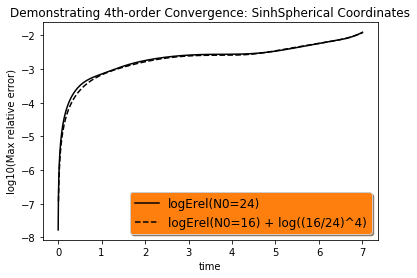

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpmath as mp
import csv

def file_reader(filename):
    with open(filename) as file:
        reader = csv.reader(file, delimiter=" ")
        data  = list(zip(*reader))
        # data is a tuple of strings. Tuples are immutable, and we need to perform math on
        #   the data, so here we convert tuple to lists of floats:
        data0 = []
        data1 = []
        for i in range(len(data[0])):
            data0.append(float(data[0][i]))
            data1.append(float(data[1][i]))
        return data0,data1

first_col16,second_col16 = file_reader('out-lowresolution.txt')
first_col24,second_col24 = file_reader('out-medresolution.txt')

second_col16_rescaled4o = []
second_col16_rescaled5o = []
for i in range(len(second_col16)):
    # data16 = data24*(16/24)**4
    # -> log10(data24) = log10(data24) + 4*log10(16/24)
    second_col16_rescaled4o.append(second_col16[i] + 4*mp.log10(16./24.))
    second_col16_rescaled5o.append(second_col16[i] + 5*mp.log10(16./24.))

# https://matplotlib.org/gallery/text_labels_and_annotations/legend.html#sphx-glr-gallery-text-labels-and-annotations-legend-py        
fig, ax = plt.subplots()

plt.title("Demonstrating 4th-order Convergence: "+par.parval_from_str("reference_metric::CoordSystem")+" Coordinates")
plt.xlabel("time")
plt.ylabel("log10(Max relative error)")

ax.plot(first_col24, second_col24, 'k-', label='logErel(N0=24)')
ax.plot(first_col16, second_col16_rescaled4o, 'k--', label='logErel(N0=16) + log((16/24)^4)')
if par.parval_from_str("reference_metric::CoordSystem") == "Cylindrical":
    ax.plot(first_col16, second_col16_rescaled5o, 'k.',  label='(Assuming 5th-order convergence)')
legend = ax.legend(loc='lower right', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('C1')
plt.show()

<a id='latex_pdf_output'></a>

# Step 5: Output this module to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-ScalarWaveCurvilinear.pdf](Tutorial-Start_to_Finish-ScalarWaveCurvilinear.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [9]:
!jupyter nbconvert --to latex --template latex_nrpy_style.tplx Tutorial-Start_to_Finish-ScalarWaveCurvilinear.ipynb
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-ScalarWaveCurvilinear.tex
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-ScalarWaveCurvilinear.tex
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-ScalarWaveCurvilinear.tex
!rm -f Tut*.out Tut*.aux Tut*.log

[NbConvertApp] Converting notebook Tutorial-Start_to_Finish-ScalarWaveCurvilinear.ipynb to latex
[NbConvertApp] Writing 90644 bytes to Tutorial-Start_to_Finish-ScalarWaveCurvilinear.tex
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
